# Online Learning Experiments - Group Project

This notebook contains all experiments for the Online Learning project, organized in a modular and scalable way.

## Table of Contents
1. [Setup and Imports](#setup)
2. [Experiment Configuration Framework](#framework)
3. [Task 1.1: UCB1 Simple Pricing](#task1_1)
4. [Task 1.2: Constrained UCB Pricing](#task1_2)
5. [Task 2.1: Combinatorial UCB Multi-Product](#task2_1)
6. [Task 3.1: Primal-Dual Non-Stationary](#task3_1)
7. [Task 4.1: Multi-Product Primal-Dual](#task4_1)
8. [Task 5.1: Sliding Window Non-Stationarity](#task5_1)

## Setup and Imports

In [25]:
%load_ext autoreload
%autoreload 2

print("Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Autoreload abilitato - i moduli verranno ricaricati automaticamente quando modificati


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Any
from collections import deque
import time

warnings.filterwarnings('ignore')

# Import custom modules
from environments import *
from agents import *
from data_generators import *
from utils import *

# Configure plotting
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup completed successfully!")


Setup completed successfully!


In [27]:
@dataclass
class ExperimentConfig:
    """Standard configuration for all experiments"""
    task_name: str
    horizon: int
    n_trials: int
    seed: int
    prices: np.ndarray
    n_products: int = 1
    budget: Optional[int] = None
    
    def __post_init__(self):
        pass

@dataclass
class ExperimentResult:
    """Standard result container for all experiments"""
    config: ExperimentConfig
    regrets: List[List[float]]
    units_sold: List[List[int]]
    final_rewards: List[float]
    execution_time: float
    clairvoyant_reward: Optional[float] = None
    final_agents: List = field(default_factory=list)
    
    def __post_init__(self):
        pass

class StandardExperimentRunner:
    """Standard experiment runner that works with any environment/agent combination"""
    
    def __init__(self, config: ExperimentConfig):
        self.config = config
        
    def create_environment(self, trial_seed: int):
        """Factory method for creating environments - override for specific tasks"""
        raise NotImplementedError("Subclasses must implement create_environment")
        
    def create_agent(self, trial_seed: int):
        """Factory method for creating agents - override for specific tasks"""
        raise NotImplementedError("Subclasses must implement create_agent")

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        raise NotImplementedError("Subclasses must implement compute_clairvoyant_reward")
        
    def extract_metrics(self, result) -> Tuple[float, float]:
        """Extract reward and cost from environment result - override for specific tasks"""
        if isinstance(result, tuple) and len(result) >= 2:
            reward_raw = result[0]
            cost_raw = result[1]
        elif isinstance(result, tuple) and len(result) == 1:
            reward_raw = result[0]
            cost_raw = 1.0
        else:
            reward_raw = result
            cost_raw = 1.0
            
        reward = float(np.sum(reward_raw))
        cost = float(np.sum(cost_raw))
            
        return reward, cost
        
    def run_single_trial(self, trial: int) -> Tuple[List[float], List[int], float, Any]:
        """Run a single trial and return regrets, units sold, final reward, and final agent"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent(trial_seed)
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0.0
        
        clairvoyant_reward = self.compute_clairvoyant_reward()
        
        for t in range(self.config.horizon):
            action = agent.pull_arm()
            
            if action is None:
                print(f"Trial {trial+1}: Agent stopped at round {t}.", end=" ")
                break
                
            result = env.round(action)
            
            if isinstance(result, tuple):
                agent.update(*result)
            else:
                agent.update(result)
            
            reward, cost = self.extract_metrics(result)
                
            cum_reward += reward
            cum_units += cost
            
            instant_regret = clairvoyant_reward - reward
            cum_regret += instant_regret
            
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))
            
        return regrets, units_sold, cum_reward, agent
        
    def run_experiment(self) -> ExperimentResult:
        """Run the complete experiment"""
        print(f"Running {self.config.task_name}")
        print(f"Horizon: {self.config.horizon}, Trials: {self.config.n_trials}")
        
        start_time = time.time()
        
        all_regrets = []
        all_units_sold = []
        final_rewards = []
        final_agents = []
        
        for trial in range(self.config.n_trials):
            print(f"Trial {trial+1}/{self.config.n_trials}...", end=" ")
            regrets, units_sold, final_reward, agent = self.run_single_trial(trial)
            all_regrets.append(regrets)
            all_units_sold.append(units_sold)
            final_rewards.append(final_reward)
            final_agents.append(agent)
            print("✓")
            
        execution_time = time.time() - start_time
        
        result = ExperimentResult(
            config=self.config,
            regrets=all_regrets,
            units_sold=all_units_sold,
            final_rewards=final_rewards,
            execution_time=execution_time,
            clairvoyant_reward=self.compute_clairvoyant_reward(),
            final_agents=final_agents
        )
        
        return result

print("Experiment framework created successfully!")


Experiment framework created successfully!


In [28]:
class StandardPlotter:
    """Standard plotting utilities for all experiments"""
    
    @staticmethod
    def plot_experiment_results(result: ExperimentResult, show_units: bool = True):
        """Standard plotting for experiment results"""
        all_regrets = result.regrets
        all_units = result.units_sold
        
        # Find minimum length across trials
        min_rounds = min(len(regrets) for regrets in result.regrets)
        
        # Truncate to minimum length and convert to arrays
        truncated_regrets = np.array([regrets[:min_rounds] for regrets in all_regrets])
        truncated_units = np.array([units[:min_rounds] for units in all_units])
        
        # Compute statistics
        avg_regret = truncated_regrets.mean(axis=0)
        std_regret = truncated_regrets.std(axis=0)
        avg_units = truncated_units.mean(axis=0)
        
        # Create plots
        fig_width = 16 if show_units else 12
        fig, axes = plt.subplots(1, 2 if show_units else 1, figsize=(fig_width, 6))
        
        if not show_units:
            axes = [axes]
            
        # Regret plot
        axes[0].plot(avg_regret, 'b-', linewidth=2, label="Average Cumulative Regret")
        if result.config.n_trials > 1:
            se_regret = std_regret / np.sqrt(result.config.n_trials)
            axes[0].fill_between(
                range(min_rounds),
                avg_regret - se_regret,
                avg_regret + se_regret,
                alpha=0.3,
                color='blue',
                label="±1 SE"
            )
        axes[0].set_xlabel("Round")
        axes[0].set_ylabel("Cumulative Regret")
        axes[0].set_title(f"{result.config.task_name}: Cumulative Regret")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Units sold plot
        if show_units:
            axes[1].plot(avg_units, 'g-', linewidth=2, label="Average Units Sold")
            axes[1].set_xlabel("Round")
            axes[1].set_ylabel("Cumulative Units Sold")
            axes[1].set_title(f"{result.config.task_name}: Units Sold")
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            # Add budget line if available
            if result.config.budget is not None:
                axes[1].axhline(y=result.config.budget, color='r', linestyle='--', 
                              label=f"Budget: {result.config.budget}")
                axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        return avg_regret, avg_units, min_rounds
    
    @staticmethod
    def plot_arm_distribution(agent, prices: NDArray[np.float64] | List[NDArray[np.float64]], title: str = "Arm Distribution"):
        """Plot the distribution of arm pulls"""
        if hasattr(agent, 'N_pulls'):
            plt.figure(figsize=(10, 6))
            if isinstance(agent.N_pulls, np.ndarray) and agent.N_pulls.ndim == 1:
                # Single product
                labels = [f"{p:.3f}" for p in prices]
                plt.bar(labels, agent.N_pulls)
                plt.xlabel("Price")
                plt.ylabel("Number of Pulls")
                plt.title(title)
                plt.xticks(rotation=45)
            else:
                # Multi-product
                n_products = len(agent.N_pulls)
                fig, axes = plt.subplots(1, n_products, figsize=(4*n_products, 4))
                if n_products == 1:
                    axes = [axes]
                
                for j in range(n_products):
                    labels = [f"{p:.3f}" for p in prices[j]]
                    axes[j].bar(labels, agent.N_pulls[j])
                    axes[j].set_xlabel("Price")
                    axes[j].set_ylabel("Number of Pulls")
                    axes[j].set_title(f"Product {j+1}")
                    axes[j].tick_params(axis='x', rotation=45)
                
                plt.suptitle(title)
            plt.tight_layout()
            plt.show()

class StandardAnalyzer:
    """Standard analysis utilities for all experiments"""
    
    @staticmethod
    def analyze_results(result: ExperimentResult) -> Dict[str, Any]:
        """Standard analysis of experiment results"""
        min_rounds = min(len(regrets) for regrets in result.regrets)
        
        # Basic statistics
        final_regrets = [regrets[-1] if regrets else 0 for regrets in result.regrets]
        avg_regret_per_round = np.mean(final_regrets) / min_rounds if min_rounds > 0 else 0
        avg_final_reward = np.mean(result.final_rewards)
        std_final_reward = np.std(result.final_rewards)
        
        # Efficiency metrics
        efficiency = None
        if result.clairvoyant_reward is not None and result.clairvoyant_reward > 0:
            baseline_total = result.clairvoyant_reward * min_rounds
            efficiency = 100 * avg_final_reward / baseline_total
        
        analysis = {
            'min_rounds': min_rounds,
            'avg_regret_per_round': avg_regret_per_round,
            'avg_final_reward': avg_final_reward,
            'std_final_reward': std_final_reward,
            'efficiency_percent': efficiency,
            'execution_time': result.execution_time
        }
        
        return analysis
    
    @staticmethod
    def print_analysis(result: ExperimentResult, analysis: Dict[str, Any]):
        """Print standard analysis results"""
        print(f"\n{'='*60}")
        print(f"RESULTS FOR {result.config.task_name}")
        print(f"{'='*60}")
        print(f"Execution time: {analysis['execution_time']:.2f} seconds")
        print(f"Completed rounds: {analysis['min_rounds']}")
        print(f"Average regret per round: {analysis['avg_regret_per_round']:.6f}")
        print(f"Average final reward: {analysis['avg_final_reward']:.2f} ± {analysis['std_final_reward']:.2f}")
        
        if analysis['efficiency_percent'] is not None:
            print(f"Efficiency vs clairvoyant: {analysis['efficiency_percent']:.1f}%")
        
        if result.config.budget is not None:
            final_units = [units[-1] if units else 0 for units in result.units_sold]
            avg_units = np.mean(final_units)
            print(f"Average units sold: {avg_units:.2f}/{result.config.budget} ({100*avg_units/result.config.budget:.1f}%)")
        
        print(f"{'='*60}")

print("Plotting and analysis utilities created successfully!")


Plotting and analysis utilities created successfully!


## <a id="task1_1"></a>Task 1.1: UCB1 Simple Pricing

Implementation of UCB1 for the pricing problem with uniform valuations.

Task 1.1 - UCB1 Simple Pricing
Prices: [0.1 0.2 0.3 0.5 0.7 0.8]
Expected revenues: [0.09 0.16 0.21 0.25 0.21 0.16]
Best clairvoyant price: 0.5 (idx 3)
Running Task 1.1 - UCB1 Simple Pricing
Horizon: 150000, Trials: 2
Trial 1/2... ✓
Trial 2/2... ✓


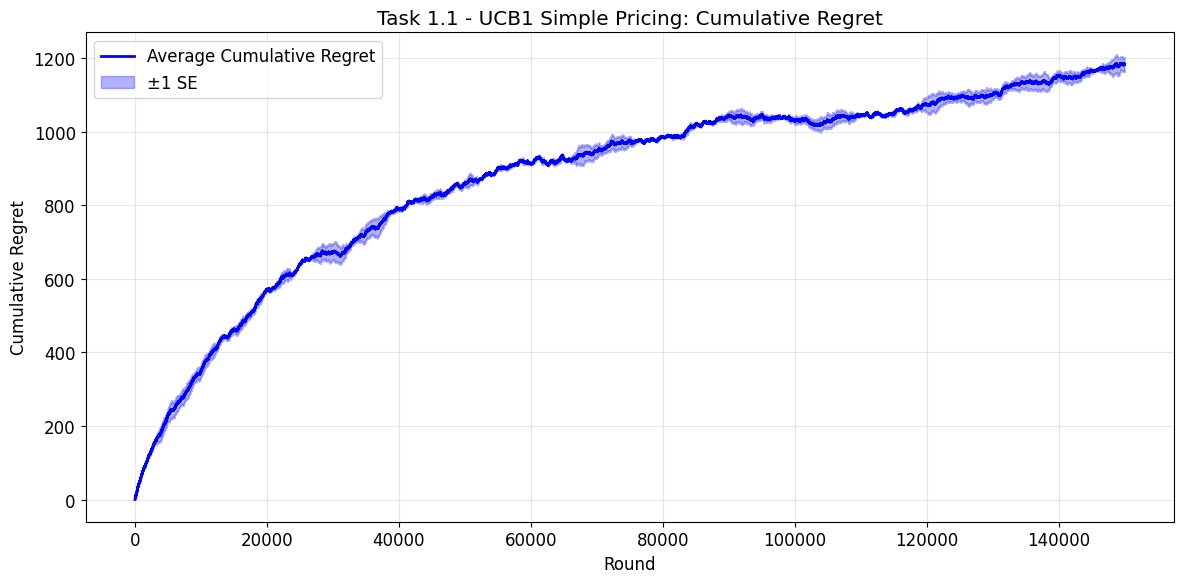

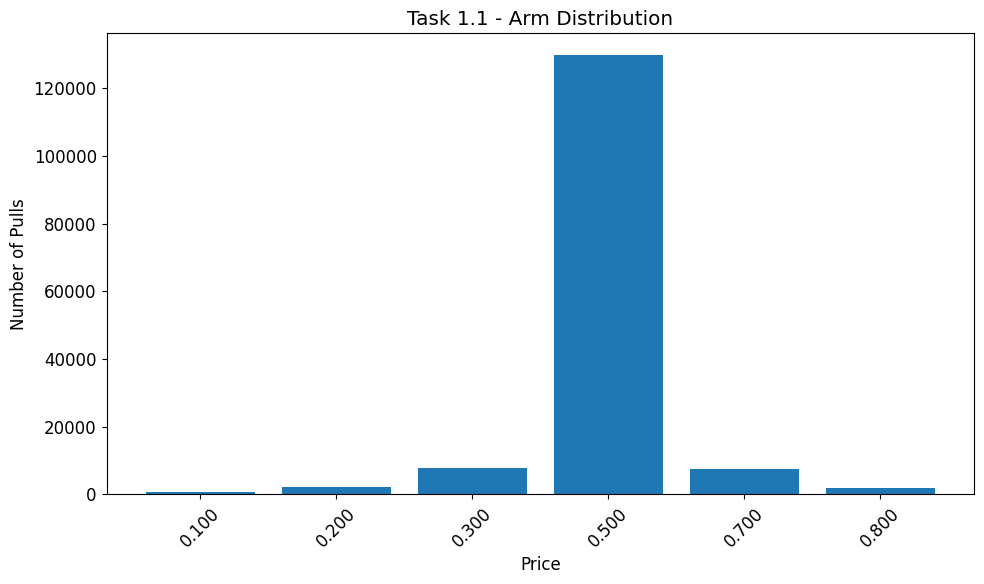


RESULTS FOR Task 1.1 - UCB1 Simple Pricing
Execution time: 4.66 seconds
Completed rounds: 150000
Average regret per round: 0.007897
Average final reward: 36315.40 ± 24.80
Efficiency vs clairvoyant: 96.8%

Detailed Results:
Expected revenues: [0.09 0.16 0.21 0.25 0.21 0.16]
Empirical average rewards: [0.0896 0.1616 0.2077 0.2497 0.2069 0.1545]


In [5]:
class Task1_1_Runner(StandardExperimentRunner):
    """UCB1 Simple Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.expected_revenues = self.prices * (1 - self.prices)
        self.best_idx = np.argmax(self.expected_revenues)
        self.clairvoyant_reward_per_round = self.expected_revenues[self.best_idx]
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return PricingEnvironment(self.prices, self.config.horizon, rng=rng)
        
    def create_agent(self, trial_seed: int):
        return UCB1PricingAgent(len(self.prices), self.config.horizon)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clairvoyant_reward_per_round
        
    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result), 1.0

prices = create_simple_prices()
config = ExperimentConfig(
    task_name="Task 1.1 - UCB1 Simple Pricing",
    horizon=150_000,
    n_trials=2,
    seed=18,
    prices=prices
)

print(f"Task 1.1 - UCB1 Simple Pricing")
print(f"Prices: {prices}")

expected_revenues = prices * (1 - prices)
best_idx = np.argmax(expected_revenues)
best_price = prices[best_idx]

print(f"Expected revenues: {np.round(expected_revenues, 6)}")
print(f"Best clairvoyant price: {best_price} (idx {best_idx})")

# Run experiment
runner = Task1_1_Runner(config)
result: ExperimentResult = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=False)

StandardPlotter.plot_arm_distribution(result.final_agents[0], prices, "Task 1.1 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

print(f"\nDetailed Results:")
print(f"Expected revenues: {np.round(expected_revenues, 4)}")
print(f"Empirical average rewards: {np.round(result.final_agents[0].average_rewards, 4)}")

# Store result for later comparison
task1_1_result = result


## <a id="task1_2"></a>Task 1.2: Constrained UCB Pricing

Implementation of Constrained UCB for pricing with budget constraints.


Task 1.2 - Constrained UCB Pricing
Prices: 16 prices from 0.200 to 0.980
Budget: 4000, Horizon: 10000
Sell probabilities (uniform): first 5 = [0.8   0.744 0.689 0.633 0.578]
Expected rewards: first 5 = [0.16     0.190464 0.214279 0.232311 0.243916]
Clairvoyant utility per round: 0.2395
Running Task 1.2 - Constrained UCB Pricing
Horizon: 10000, Trials: 3
Trial 1/3... Trial 1: Agent stopped at round 8924. ✓
Trial 2/3... Trial 2: Agent stopped at round 8822. ✓
Trial 3/3... Trial 3: Agent stopped at round 8781. ✓


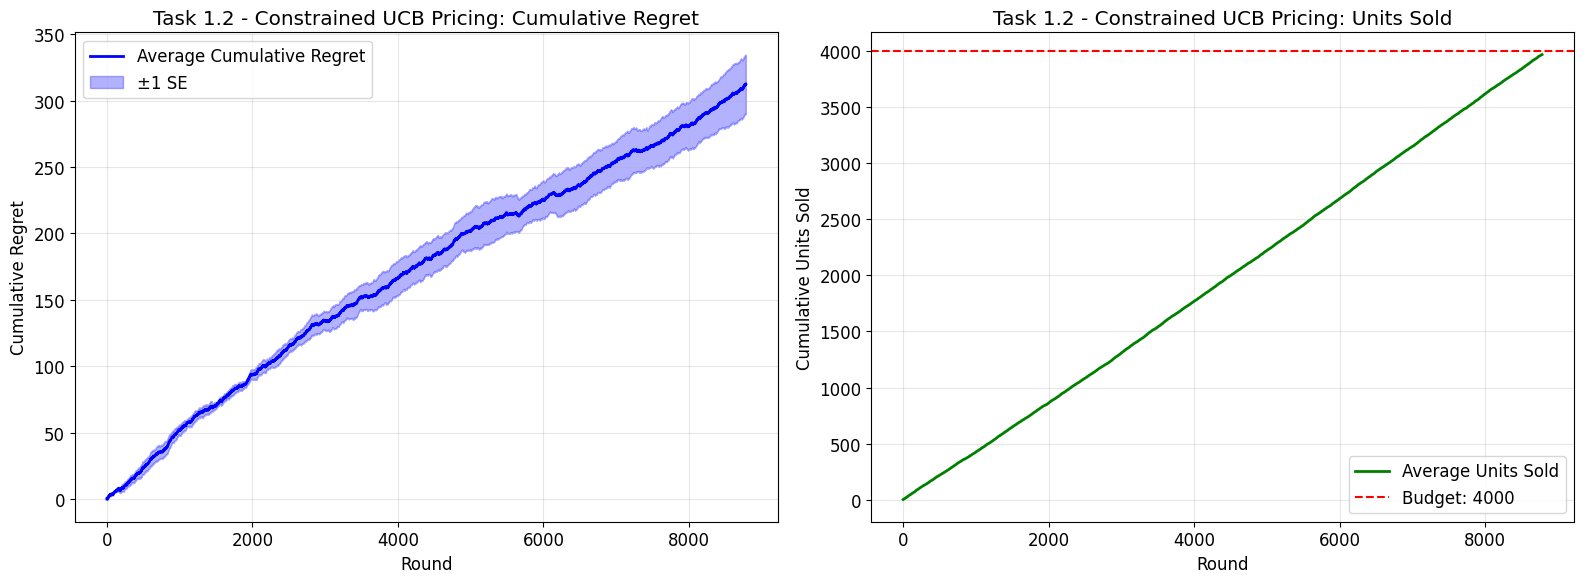

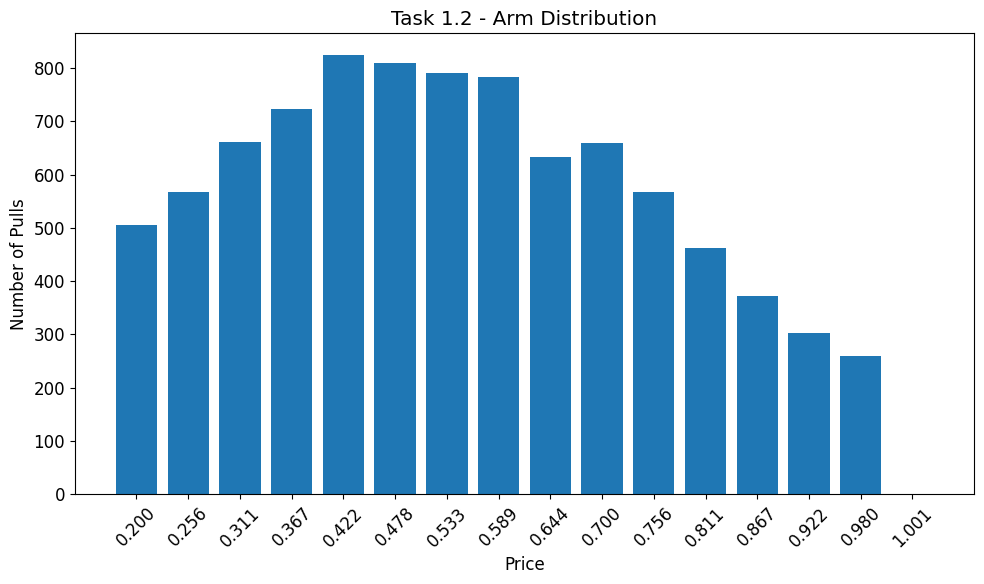


RESULTS FOR Task 1.2 - Constrained UCB Pricing
Execution time: 89.63 seconds
Completed rounds: 8781
Average regret per round: 0.035935
Average final reward: 1802.34 ± 28.61
Efficiency vs clairvoyant: 85.7%
Average units sold: 4000.00/4000 (100.0%)
Baseline reward: 2395.16


In [6]:
class Task1_2_Runner(StandardExperimentRunner):
    """Constrained UCB Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.sell_probabilities = np.maximum(0, 1 - self.prices)
        self.expected_reward = self.prices * self.sell_probabilities
        
        self.exp_util, self.gamma, self.exp_cost = compute_clairvoyant_single_product(
            self.prices, self.sell_probabilities, config.budget, config.horizon
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return BudgetedPricingEnvironment(self.prices, self.config.horizon, rng=rng)
        
    def create_agent(self, trial_seed: int):
        return ConstrainedUCBPricingAgent(len(self.prices), self.config.budget, self.config.horizon, range=2)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.exp_util
        
    def extract_metrics(self, result) -> tuple[float, float]:
        return float(result[0]), float(result[1])

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 1.2 - Constrained UCB Pricing",
    horizon=10_000,
    n_trials=3,
    seed=18,
    budget=4_000,
    prices=prices
)

print("Task 1.2 - Constrained UCB Pricing")
print(f"Prices: {len(prices)} prices from {prices[0]:.3f} to {prices[-2]:.3f}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

runner = Task1_2_Runner(config)

print(f"Sell probabilities (uniform): first 5 = {runner.sell_probabilities[:5]}")
print(f"Expected rewards: first 5 = {runner.expected_reward[:5]}")
print(f"Clairvoyant utility per round: {runner.exp_util:.4f}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

StandardPlotter.plot_arm_distribution(result.final_agents[0], prices, "Task 1.2 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

baseline_reward = runner.exp_util * config.horizon
print(f"Baseline reward: {baseline_reward:.2f}")

task1_2_result = result


## <a id="task2_1"></a>Task 2.1: Combinatorial UCB Multi-Product

Implementation of Constrained Combinatorial UCB for multi-product pricing with shared budget.


Task 2.1 - Combinatorial UCB Multi-Product
Products: 3, Prices per product: 10
Budget: 11000, Horizon: 10000
Expected revenue per price (f_true): [array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ]), array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ]), array([0.        , 0.09876543, 0.17283951, 0.22222222, 0.24691358,
       0.24691358, 0.22222222, 0.17283951, 0.09876543, 0.        ,
       0.        ])]
Expected consumption per price (c_true): [array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ,
       0.        ]), array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.44444444, 0.33333333, 0.22222222, 0.11111111, 0.        ,
       0.        ]), array([1.        , 0.88888889, 0.777

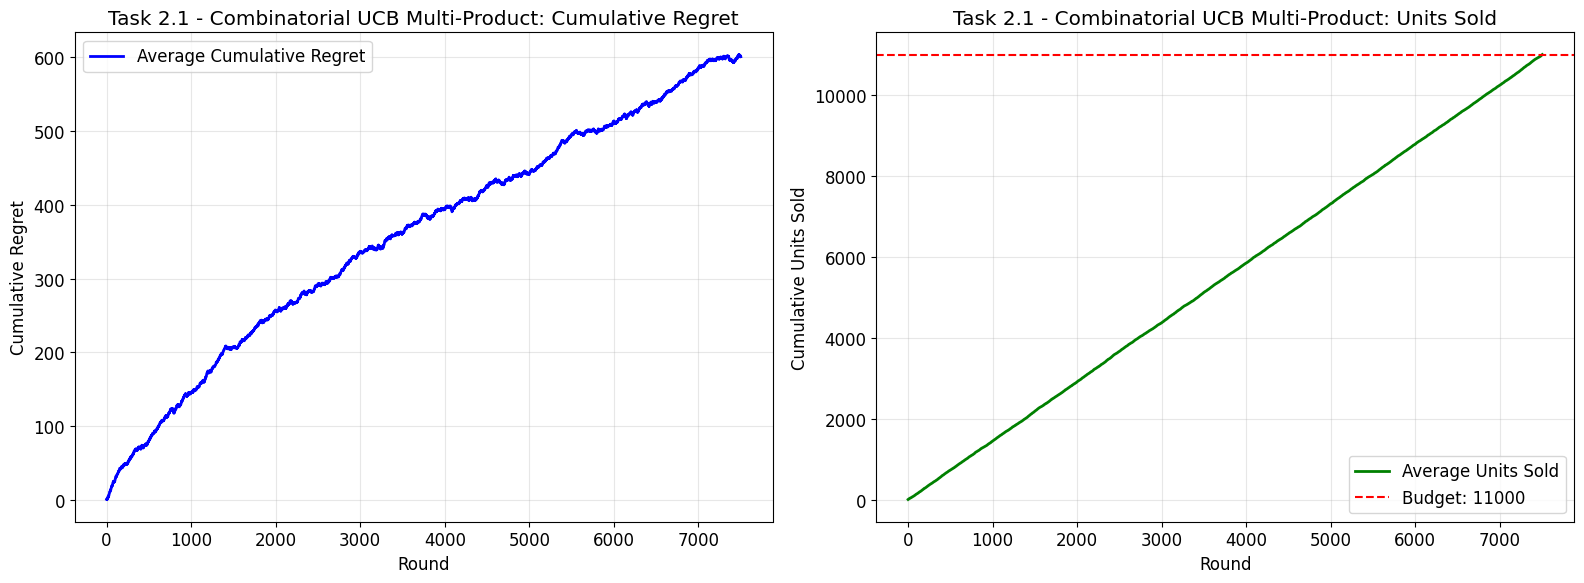

<Figure size 1000x600 with 0 Axes>

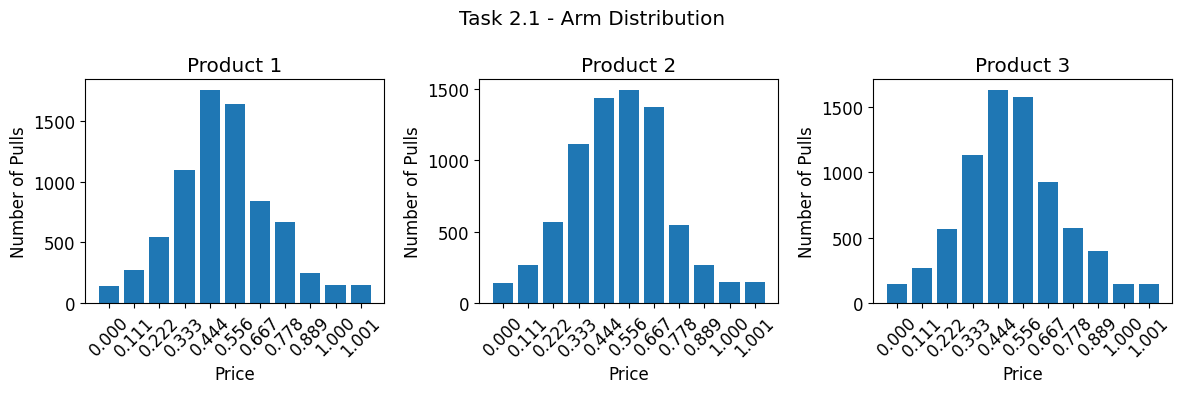


RESULTS FOR Task 2.1 - Combinatorial UCB Multi-Product
Execution time: 27.66 seconds
Completed rounds: 7503
Average regret per round: 0.080066
Average final reward: 4568.00 ± 0.00
Efficiency vs clairvoyant: 88.4%
Average units sold: 11001.00/11000 (100.0%)

Detailed Results Task 2.1:
Average regret per round: 0.0801
Average units sold: 11001.00
Budget utilization: 11001.0/11000 (100.0%)


In [15]:
class Task2_1_Runner(StandardExperimentRunner):
    """Combinatorial UCB Multi-Product experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.n_products = config.n_products
        self.price_grid = [np.concatenate([config.prices, [1.001]]) for _ in range(self.n_products)]
        
        self.clair_reward, self.simplex = solve_clairvoyant_lp(self.price_grid, config.budget, config.horizon)
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return MultiProductPricingEnvironment(self.price_grid, self.config.horizon, rng=rng)
        
    def create_agent(self, trial_seed: int):
        return ConstrainedCombinatorialUCBAgent(self.price_grid, self.config.budget, self.config.horizon, alpha=2)
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))

N_products = 3
price_grid = np.linspace(0, 1, 10)

config = ExperimentConfig(
    task_name="Task 2.1 - Combinatorial UCB Multi-Product",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=11_000,
    prices=price_grid,
    n_products=N_products
)

print(f"Task 2.1 - Combinatorial UCB Multi-Product")
print(f"Products: {N_products}, Prices per product: {len(price_grid)}")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")

# Run experiment
runner = Task2_1_Runner(config)

print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex solution shape: {np.array(runner.simplex).shape}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

StandardPlotter.plot_arm_distribution(result.final_agents[0], runner.price_grid, "Task 2.1 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

print(f"\nDetailed Results Task 2.1:")
if analysis['min_rounds'] > 0:
    print(f"Average regret per round: {analysis['avg_regret_per_round']:.4f}")
    final_units = [units[-1] if units else 0 for units in result.units_sold]
    avg_units = np.mean(final_units)
    print(f"Average units sold: {avg_units:.2f}")
    print(f"Budget utilization: {avg_units}/{config.budget} ({100*avg_units/config.budget:.1f}%)")

task2_1_result = result


## <a id="task3_1"></a>Task 3.1: Primal-Dual Non-Stationary Pricing

Implementation of Full-Feedback Primal-Dual for non-stationary environments with adversarial shocks.


Task 3.1 - Primal-Dual Non-Stationary Pricing
Budget: 6000, Horizon: 10000
Shock probability: 0.5, Frequency: 300
Prices: 16 from 0.200 to 0.980
Running Task 3.1 - Primal-Dual Non-Stationary Pricing
Horizon: 10000, Trials: 1
Trial 1/1... Clairvoyant utility: 0.2528
Expected cost per round: 0.5288
Sell probabilities (first 5): [0.8487 0.7925 0.7276 0.6599 0.594 ]
Trial 1: Final reward = 2382.41, Budget remaining = 829
Final pull counts: [  53  107  262  935 2249 3074 1746  748  266  177   97   67   60   58
   50   51]
Final λ multiplier: 0.0080 ✓


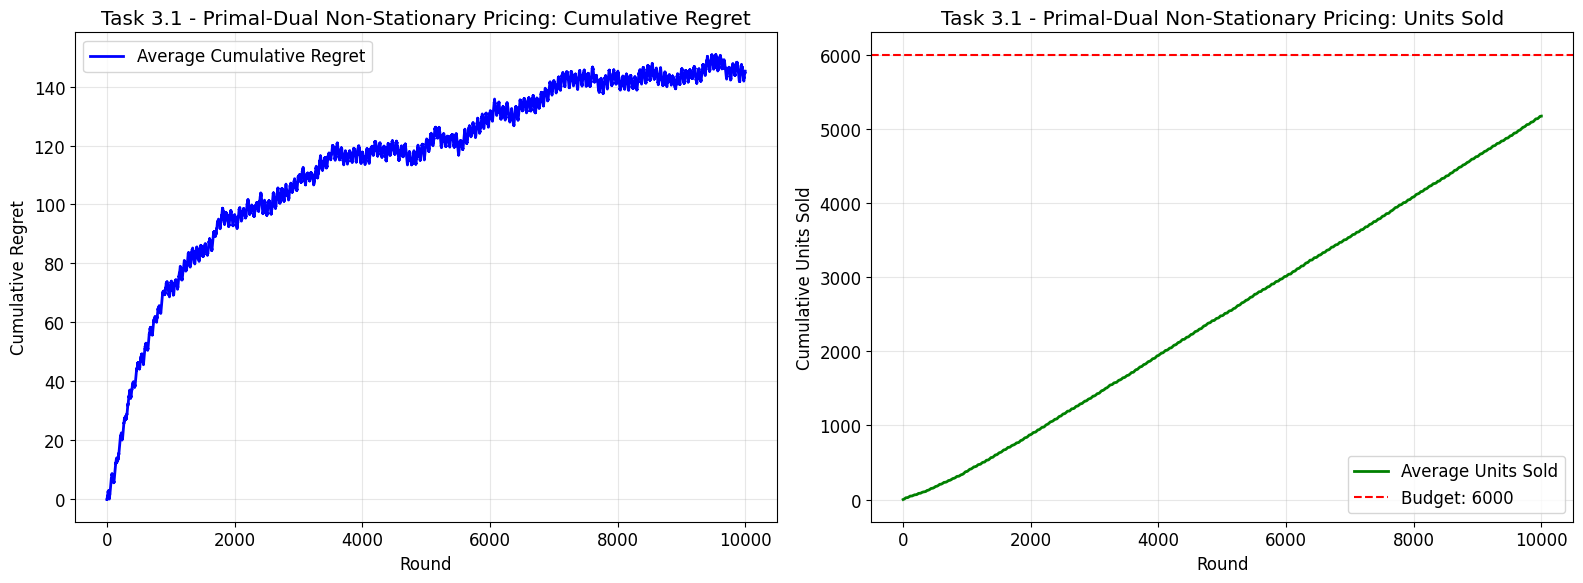


RESULTS FOR Task 3.1 - Primal-Dual Non-Stationary Pricing
Execution time: 1.41 seconds
Completed rounds: 10000
Average regret per round: 0.014526
Average final reward: 2382.41 ± 0.00
Average units sold: 5171.00/6000 (86.2%)


In [23]:
class Task3_1_Runner(StandardExperimentRunner):
    """Primal-Dual Non-Stationary Pricing experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.shock_prob = 0.50
        self.freq = 300
        
    def create_environment(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        return NonStationaryBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.shock_prob, self.freq, 
            num_regimes=10000, valuation_type='beta', rng=rng
        )
        
    def create_agent(self, trial_seed: int):
        rng = np.random.RandomState(trial_seed)
        eta = 1 / np.sqrt(self.config.horizon)
        return FFPrimalDualPricingAgent(self.prices, self.config.horizon, self.config.budget, rng=rng, eta=eta)

    def compute_clairvoyant_reward(self) -> float:
        """Compute clairvoyant reward - override for specific tasks"""
        return 0 # We override the run_single_trial method

        
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 3.1 due to special full-feedback structure"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent(trial_seed)
        
        sell_probabilities = env.compute_sell_probabilities()
        exp_util, gamma, exp_cost = compute_clairvoyant_single_product(
            self.prices, sell_probabilities, self.config.budget, self.config.horizon
        )
        
        if trial == 0:
            print(f"Clairvoyant utility: {exp_util:.4f}")
            print(f"Expected cost per round: {exp_cost:.4f}")
            print(f"Sell probabilities (first 5): {sell_probabilities[:5]}")
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        for t in range(self.config.horizon):
            arm = agent.pull_arm()
            if arm is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            valuation = env.round()
            reward, sold = agent.update(valuation)
            
            cum_reward += reward
            instant_regret = exp_util - reward
            cum_regret += instant_regret
            cum_units += sold
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))
            
        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}, Budget remaining = {agent.inventory}")
        print(f"Final pull counts: {agent.pull_counts}")
        print(f"Final λ multiplier: {agent.lmbd:.4f}", end=" ")
        
        return regrets, units_sold, cum_reward, agent

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 3.1 - Primal-Dual Non-Stationary Pricing",
    horizon=10_000,
    n_trials=1,
    seed=17,
    budget=6_000,
    prices=prices
)

print(f"Task 3.1 - Primal-Dual Non-Stationary Pricing")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Shock probability: {0.50}, Frequency: {300}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")

runner = Task3_1_Runner(config)
result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task3_1_result = result


## Task 4.1: Multi-Product Primal-Dual

Implementazione di Multi-Product Full-Feedback Primal-Dual per ambienti correlati multi-prodotto.


Task 4.1 - Multi-Product Primal-Dual
Products: 4, Budget: 80000, Horizon: 100000
Prices: 16 from 0.200 to 0.980
Correlation parameters: μ₀=0.5, ρ₀=0.6
Running Task 4.1 - Multi-Product Primal-Dual
Horizon: 100000, Trials: 1
Trial 1/1... Clairvoyant reward per round: 0.5071
Expected cost per round: 0.8000
Optimal gamma shape: (4, 16)
Average gamma per product: [0.0625 0.0625 0.0625 0.0625]
Trial 1: Final cumulative reward = 48215.38
Trial 1: Budget remaining = 369
Trial 1: Final λ = 1.2270
✓


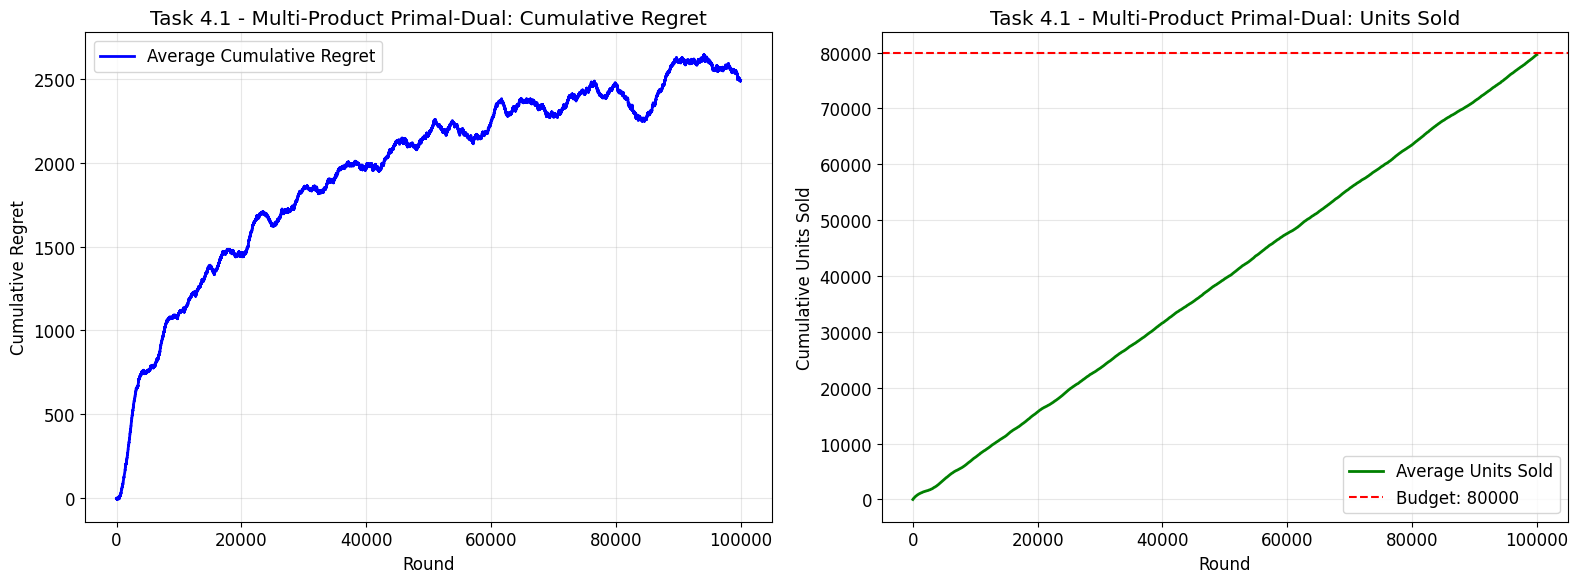


RESULTS FOR Task 4.1 - Multi-Product Primal-Dual
Execution time: 49.87 seconds
Completed rounds: 100000
Average regret per round: 0.024935
Average final reward: 48215.38 ± 0.00
Average units sold: 79631.00/80000 (99.5%)


In [24]:
class Task4_1_Runner(StandardExperimentRunner):
    """Multi-Product Primal-Dual experiment runner"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.prices = config.prices
        self.n_products = config.n_products
        
        self.phi = np.zeros(self.n_products)
        self.mu0, self.A, self.f = 0.5, 0.1, 100
        self.sigma0, self.A_sigma, self.phi_sigma, self.rho0 = 0.1, 0.1, 0, 0.6
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        valuation_params = {
            'mu0': self.mu0, 'A': self.A, 'f': self.f, 'phi': self.phi,
            'sigma0': self.sigma0, 'A_sigma': self.A_sigma, 'phi_sigma': self.phi_sigma, 'rho0': self.rho0,
            'num_regimes': 10000
        }
        return MultiProductBudgetedPricingEnvironment(
            self.prices, self.config.horizon, self.n_products, valuation_params, valuation_type='piecewise_tv', rng=rng
        )
        
    def create_agent(self, trial_seed: int) -> MultiProductFFPrimalDualPricingAgent:
        rng = np.random.default_rng(trial_seed)
        eta = 1 / np.sqrt(self.config.horizon)
        return MultiProductFFPrimalDualPricingAgent(self.prices, self.config.horizon, self.config.budget, self.n_products, rng, eta)
        
    def compute_clairvoyant_reward(self) -> float:
        return 0 # We override the run_single_trial method
        
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 4.1 due to special full-feedback multi-product structure"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        trial_rng = np.random.default_rng(trial_seed)
        
        V, _ = generate_piecewise_tv_mv_gauss(self.config.horizon, self.n_products, num_regimes=10000, rng=trial_rng)
        
        exp_util, gamma, exp_cost = compute_extended_clairvoyant(V, self.prices, self.config.budget)
        
        if trial == 0:
            print(f"Clairvoyant reward per round: {exp_util:.4f}")
            print(f"Expected cost per round: {exp_cost:.4f}")
            print(f"Optimal gamma shape: {gamma.shape}")
            print(f"Average gamma per product: {gamma.mean(axis=1)}")
        
        env = self.create_environment(trial_seed)
        env.V = V
        
        agent = self.create_agent(trial_seed)
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        for t in range(self.config.horizon):
            if agent.inventory < 1:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            v_t = env.round()
            reward, sold = agent.update(v_t)
            
            cum_reward += reward
            instant_regret = exp_util - reward
            cum_regret += instant_regret
            cum_units += sold
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))
            
        print(f"Trial {trial+1}: Final cumulative reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget remaining = {agent.inventory}")
        print(f"Trial {trial+1}: Final λ = {agent.lmbd:.4f}")

        
        return regrets, units_sold, cum_reward, agent

prices = create_default_prices()
config = ExperimentConfig(
    task_name="Task 4.1 - Multi-Product Primal-Dual",
    horizon=100_000,
    n_trials=1,
    seed=42,
    budget=80_000,
    prices=prices,
    n_products=4
)

print(f"Task 4.1 - Multi-Product Primal-Dual")
print(f"Products: 4, Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices: {len(prices)} from {prices[0]:.3f} to {prices[-2]:.3f}")
print(f"Correlation parameters: μ₀=0.5, ρ₀=0.6")

runner = Task4_1_Runner(config)
result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task4_1_result = result


## Task 5.1: Sliding Window per Non-Stazionarietà

Implementazione di Constrained Combinatorial UCB con Sliding Window per adattamento locale a cambiamenti.


Task 5.1 - Smooth Multi-Product Pricing
Products: 3, Temporal windows: 4
Budget: 10000, Horizon: 10000
Prices per product: 16
Clairvoyant expected reward per round: 0.6001
Simplex: [[ 0.          0.          0.          0.          0.          0.
   0.         -0.          1.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.69224556  0.30775444  0.          0.          0.
   0.          0.          0.          0.        ]]
Window size: 2039
Running Task 5.1 - Smooth Multi-Product Pricing
Horizon: 10000, Trials: 1
Trial 1/1... Trial 1/1...
Trial 1: Budget exhausted at round 5799.
Trial 1: Final reward = 3237.64
Trial 1: Budget used = 10000.0/10000 (100.0%)
Trial 1: Final regret per round 

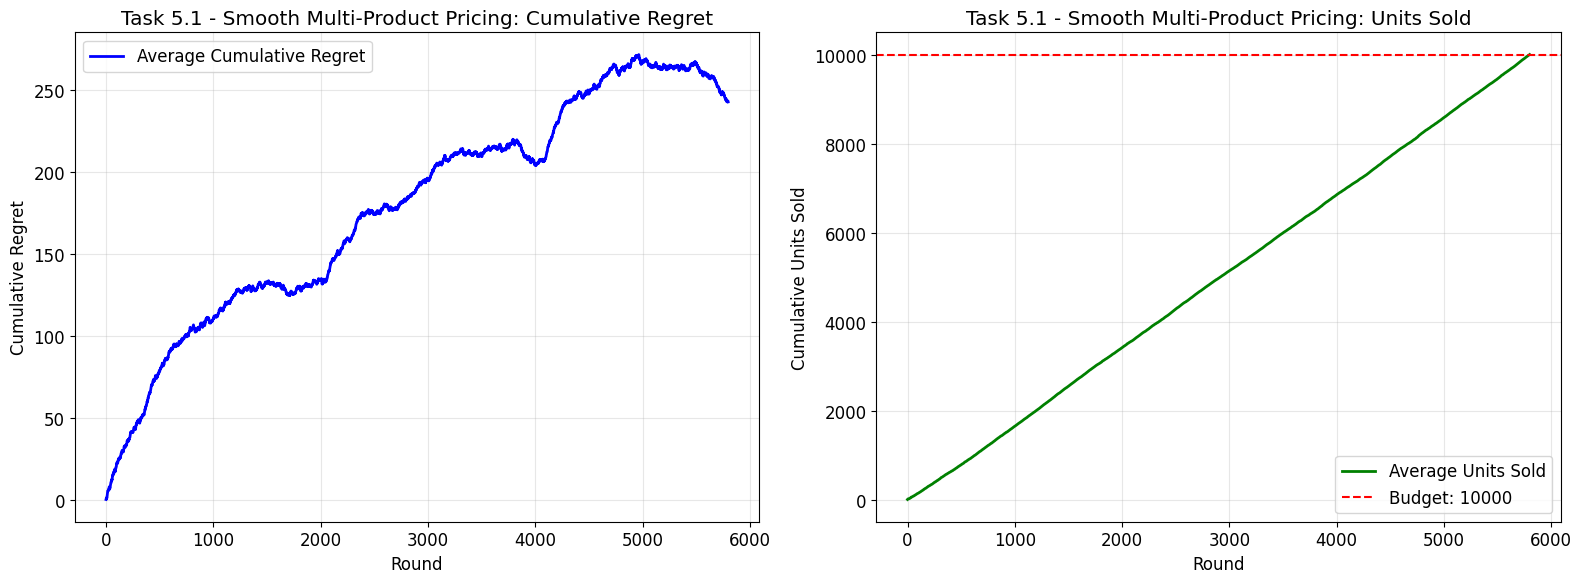


RESULTS FOR Task 5.1 - Smooth Multi-Product Pricing
Execution time: 79.53 seconds
Completed rounds: 5799
Average regret per round: 0.041829
Average final reward: 3237.64 ± 0.00
Efficiency vs clairvoyant: 93.0%
Average units sold: 10000.00/10000 (100.0%)


In [29]:
class Task5_1_Runner(StandardExperimentRunner):
    """Smooth Multi-Product Pricing with Sliding Window UCB"""
    
    def __init__(self, config: ExperimentConfig):
        super().__init__(config)
        self.N_products = config.n_products
        self.price_grid = [
            np.concatenate([config.prices, [1.001]])
            for _ in range(self.N_products)
        ]
        self.num_windows = 4
        self.window_size = int((config.horizon * np.log(config.horizon)) ** (2/3))
        
        # Generate valuation data for clairvoyant computation
        rng_val = np.random.default_rng(config.seed)
        self.expected_means, self.V = generate_one_sided_valuation_data(
            config.horizon, segments=self.num_windows, products=self.N_products,
            max_jump=0.02, transition_frac=0.2, concentration=10, rng=rng_val
        )
        
        # Compute clairvoyant reward
        full_prices = self.price_grid[0]
        self.clair_reward, self.simplex, self.expected_cost = compute_extended_clairvoyant(
            self.V, full_prices, config.budget
        )
        
    def create_environment(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return SmoothMultiProductPricingEnvironment(
            self.price_grid, self.config.horizon, valuations=self.V, rng=rng
        )
        
    def create_agent(self, trial_seed: int):
        rng = np.random.default_rng(trial_seed)
        return SlidingConstrainedCombinatorialUCBAgent(
            self.price_grid, self.config.budget, self.config.horizon, 
            window_size=self.window_size, rng=rng
        )
        
    def compute_clairvoyant_reward(self) -> float:
        return self.clair_reward
        
    def extract_metrics(self, result) -> tuple[float, float]:
        rewards, costs = result
        return float(np.sum(rewards)), float(np.sum(costs))
    
    def run_single_trial(self, trial: int):
        """Custom trial runner for Task 5.2 with smooth valuation data"""
        trial_seed = self.config.seed + trial
        np.random.seed(trial_seed)
        
        env = self.create_environment(trial_seed)
        agent = self.create_agent(trial_seed)
        
        regrets = []
        units_sold = []
        cum_reward = 0.0
        cum_regret = 0.0
        cum_units = 0
        
        print(f"Trial {trial+1}/{self.config.n_trials}...")
        
        for t in range(self.config.horizon):
            choice = agent.pull_arm()
            if choice is None:
                print(f"Trial {trial+1}: Budget exhausted at round {t}.")
                break
                
            rewards, costs, _ = env.round(choice)  # valuations returned but not used
            
            # Synchronize agent time with environment's time
            agent.t = env.t
            agent.update(rewards, costs)

            actual_rew = rewards.sum()
            actual_units = costs.sum()
            cum_reward += actual_rew
            
            # Compute instantaneous regret
            instant_regret = self.clair_reward - actual_rew
            cum_regret += instant_regret
            cum_units += actual_units
            regrets.append(cum_regret)
            units_sold.append(int(cum_units))

        print(f"Trial {trial+1}: Final reward = {cum_reward:.2f}")
        print(f"Trial {trial+1}: Budget used = {cum_units}/{self.config.budget} ({100*cum_units/self.config.budget:.1f}%)")
        if len(regrets) > 0:
            regret_per_round = cum_regret / float(len(regrets))
            print(f"Trial {trial+1}: Final regret per round = {regret_per_round:.4f}")
        else:
            print(f"Trial {trial+1}: No regret data collected")
        
        return regrets, units_sold, cum_reward, agent

# Configurazione del Task 5.2
N_products = 3
base_prices = np.linspace(0, 1, 15)

config = ExperimentConfig(
    task_name="Task 5.1 - Smooth Multi-Product Pricing",
    horizon=10_000,
    n_trials=1,
    seed=18,
    budget=10_000,
    prices=base_prices,
    n_products=N_products
)

print(f"Task 5.1 - Smooth Multi-Product Pricing")
print(f"Products: {N_products}, Temporal windows: 4")
print(f"Budget: {config.budget}, Horizon: {config.horizon}")
print(f"Prices per product: {len(base_prices) + 1}")

runner = Task5_1_Runner(config)
print(f"Clairvoyant expected reward per round: {runner.clair_reward:.4f}")
print(f"Simplex: {runner.simplex}")
print(f"Window size: {runner.window_size}")

result = runner.run_experiment()

StandardPlotter.plot_experiment_results(result, show_units=True)

if result.final_agents:
    StandardPlotter.plot_arm_distribution(result.final_agents[0], base_prices, "Task 5.1 - Arm Distribution")

analysis = StandardAnalyzer.analyze_results(result)
StandardAnalyzer.print_analysis(result, analysis)

task5_1_result = result